In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

import sklearn.decomposition as decomp

import seaborn as sns

np.random.seed(1024)

In [2]:
datafile = "/home/hideaki/SynologyNFS/myProgram/pythonProj/KaggleData/TwoSigma/train.h5"
#datafile = "/Users/donchan/Documents/myData/KaggleData/TwoSigma/train.h5"

hfdata = pd.HDFStore(datafile,"r")
train = hfdata.get("train")
uniq_timestamp = train["timestamp"].unique()
uniq_id = train["id"].unique()

i = len(uniq_timestamp) / 2

print("half size of length of timestanp  %d" %   i)

timesplit = uniq_timestamp[i]

print("timesplid : %d" % timesplit  )

half size of length of timestanp  906
timesplid : 906


In [16]:
df_train = train[train.timestamp < timesplit]
df_test = train[train.timestamp >= timesplit]
print( len(df_train), len(df_test),timesplit)
d_mean= df_train.median(axis=0)

(806298, 904458, 906)


In [18]:
d_mean.head()

id           1090.000000
timestamp     478.000000
derived_0       0.002433
derived_1       0.007521
derived_2       0.026020
dtype: float32

In [4]:
y_train = df_train['y']
print y_train.describe()
y_train = np.array(y_train)

count    806298.000000
mean          0.000256
std           0.021837
min          -0.086094
25%          -0.009334
50%          -0.000007
75%           0.009511
max           0.093498
Name: y, dtype: float64


In [8]:
excl = ["id", "sample", "y", "timestamp"]
col = [c for c in df_train.columns if c not in excl]

In [10]:
col[-10:]

[u'technical_35',
 u'technical_36',
 u'technical_37',
 u'technical_38',
 u'technical_39',
 u'technical_40',
 u'technical_41',
 u'technical_42',
 u'technical_43',
 u'technical_44']

In [11]:
train_select_col = df_train[col].copy()

In [19]:
n = train_select_col.isnull().sum(axis=1)
for c in train_select_col.columns:
    train_select_col.loc[:,c + '_nan_'] = pd.isnull(train_select_col[c])
    d_mean.loc[c + '_nan_'] = 0



In [20]:
train_select_col.loc[:,"znull"] = n

In [21]:
train_select_col.head()

,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,fundamental_3,fundamental_5,...,technical_37_nan_,technical_38_nan_,technical_39_nan_,technical_40_nan_,technical_41_nan_,technical_42_nan_,technical_43_nan_,technical_44_nan_,znull_nan_,derived_0_nan__nan_
0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,-0.179404,NaN,...,True,True,True,False,True,True,False,True,False,False
1,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,0.216281,0.09675,...,True,True,True,False,True,True,False,True,False,False
2,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,NaN,NaN,...,True,True,True,False,True,True,False,True,False,False
3,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,-0.097903,NaN,...,True,True,True,False,True,True,False,True,False,False
4,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,0.196391,NaN,...,True,True,True,False,True,True,False,True,False,False


(array([ 4714.,    27.,    23.,    31.,    21.,    33.,    21.,    26.,
           27.,    23.,    29.,    23.,    23.,    24.,    30.,    21.,
           29.,    31.,    41.,    18.,    23.,    30.,    22.,    38.,
           29.,    34.,    17.,    27.,    34.,    23.,    29.,    35.,
           37.,    42.,    31.,    22.,    34.,    17.,    36.,    37.,
           36.,    38.,    31.,    30.,    32.,    34.,    36.,    36.,
           36.,    42.,    40.,    29.,    40.,    42.,    31.,    31.,
           37.,    36.,    44.,    38.,    41.,    49.,    46.,    38.,
           46.,    35.,    40.,    39.,    35.,    52.,    54.,    38.,
           55.,    41.,    33.,    35.,    36.,    49.,    34.,    34.,
           51.,    51.,    43.,    42.,    47.,    52.,    46.,    47.,
           48.,    46.,    53.,    45.,    54.,    30.,    40.,    45.,
           54.,    32.,    57.,    51.,    54.,    75.,    65.,    60.,
           51.,    48.,    52.,    60.,    52.,    53.,    52., 

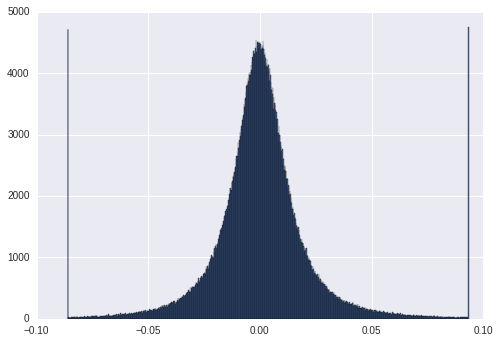

In [5]:
plt.hist(y_train,bins=1000)

In [4]:
subset = df_test[df_test.timestamp == timesplit]
print(" subset shape %s"  %   (subset.shape,) )

 subset shape (968, 111)


In [5]:
subset_topid = subset["id"].unique()[0]
print(subset_topid)

0


In [127]:
df_tmp  = df_train[df_train.id == subset_topid]
df_test_select_one  = subset[subset.id == subset_topid]

In [128]:
df_test_select_one

,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
806298,0,906,0.246848,0.102251,0.002781,-0.029337,0.400748,-0.273942,0.535335,0.243197,...,-0.193842,-4.642828e-10,-4.642828e-10,-4.436047e-10,-0.057845,-0.054224,0.000044,-1.999907,-0.052079,0.00171


In [50]:
h, w  = df_tmp.shape
print(h,w)
y = df_tmp["y"].values

(739, 111)


In [51]:
X = np.array(df_tmp)
X = X[:,2:110]
X.shape
y = np.cumsum(y)

In [52]:
def dataPCA(data,n_comp=5):

    #
    # set ZERO for NaN
    #
    data[ np.isnan(data)   ] = .0
    #
    # normalize
    #
    mu = np.mean(data,axis=0)
    sigma = np.std(data)
    data = (data - mu) / sigma

    pca = decomp.PCA(n_components = n_comp)
    pca.fit(data)
    transformed = pca.transform(data)
    E = pca.explained_variance_ratio_
    print E
    print np.cumsum(E)[::-1]
    #print transformed.shape

    m = data.shape[0]
    X = np.hstack( ( np.ones((m, 1)), transformed ) )
    #print X.shape
    return X


def computeCost(X, y, theta):
    m = len(y)
    tmp = np.dot(X, theta) - y
    J = 1.0 / (2 * m) * np.dot(tmp.T, tmp)
    return J

def gradientDescent(X, y, theta, alpha, iterations):
    m = len(y)
    J_history = []
    for iter in range(iterations):
        theta = theta - alpha * (1.0 / m) * np.dot(X.T, np.dot(X, theta) - y)
        J_history.append(computeCost(X, y, theta))
    return theta, J_history

In [54]:
X = dataPCA(X)
X.shape

[ 0.30250961  0.21145867  0.11834501  0.08800545  0.05239963]
[ 0.77271837  0.72031873  0.63231331  0.51396829  0.30250961]


(739, 6)

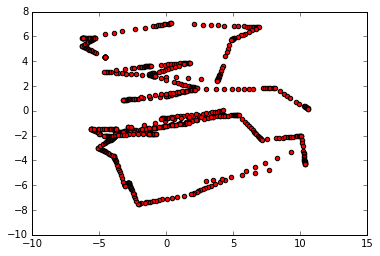

(array([ 16.,   6.,   6.,   5.,  15.,  15.,   3.,   9.,   6.,   6.,  25.,
          8.,  10.,   7.,  36.,  13.,   8.,   6.,  10.,  34.,  23.,  11.,
         10.,   9.,   6.,   6.,   8.,   8.,   5.,  15.,  17.,  17.,  16.,
          1.,  10.,   9.,   9.,  11.,   9.,  13.,   8.,   7.,   6.,   9.,
          6.,   7.,  10.,  11.,   7.,   9.,   8.,   3.,   3.,   3.,   5.,
          3.,   2.,   4.,   4.,   7.,  11.,   7.,   8.,   4.,   2.,   1.,
         11.,   5.,   4.,   4.,   3.,   5.,   2.,   4.,   3.,   4.,   7.,
          4.,   4.,   4.,   1.,   3.,   2.,   1.,   1.,   3.,   1.,   2.,
          1.,   2.,   2.,   2.,   2.,   1.,   3.,   2.,   4.,   5.,  18.,
          7.]), array([ -6.32294941,  -6.15376551,  -5.9845816 ,  -5.8153977 ,
         -5.6462138 ,  -5.4770299 ,  -5.30784599,  -5.13866209,
         -4.96947819,  -4.80029428,  -4.63111038,  -4.46192648,
         -4.29274258,  -4.12355867,  -3.95437477,  -3.78519087,
         -3.61600697,  -3.44682306,  -3.27763916,  -3.10845526,

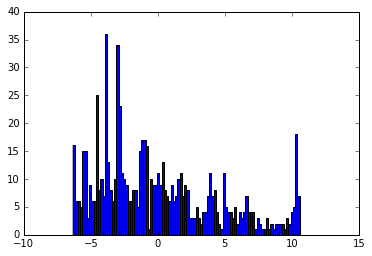

In [41]:
plt.scatter(X_pca[:,1],X_pca[:,2] , c='r' )
plt.show()
plt.hist(X_pca[:,1],bins=100)

In [74]:
n_comp = 5
theta = np.zeros(n_comp + 1)
iterations = 100000
alpha = 0.1

# calculate cost
initialCost = computeCost(X, y, theta)
#print "initial cost:", initialCost

# gradients descent
theta, J_history = gradientDescent(X, y, theta, alpha, iterations)
#print "theta:", theta
print "final cost:", J_history[-1]

y_pred = np.dot(X, theta)
len(y_pred)
print y_pred[-1] - y_pred[-2]
print df_tmp["y"].values.tolist()[-1]

final cost: 0.00275420812425
0.00165680120844
0.0103058898821


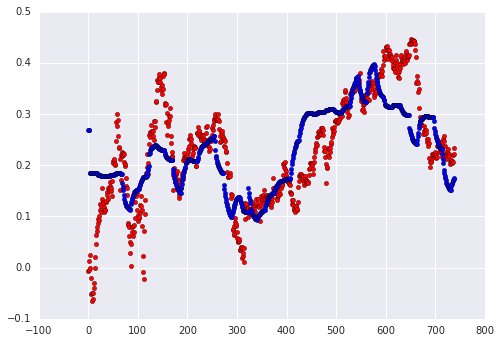

In [70]:
plt.scatter(range(h),y,c='r')
plt.scatter(range(h),y_pred,c='b')

In [75]:
y_orig = df_tmp["y"].values.tolist()

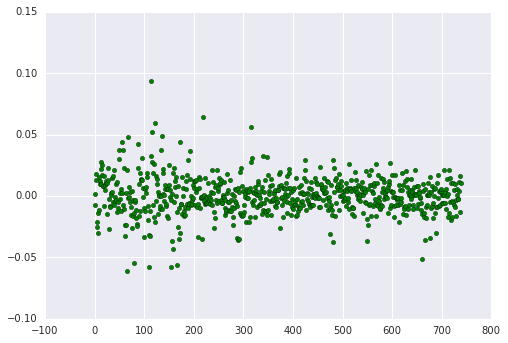

In [77]:
plt.scatter(range(h),y_orig,c='g')

(array([  1.,   1.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   3.,   5.,   3.,   3.,   4.,   1.,   0.,
          5.,   2.,   5.,   5.,   2.,   5.,  20.,  17.,  16.,  17.,  20.,
         32.,  45.,  30.,  33.,  30.,  42.,  34.,  37.,  43.,  35.,  35.,
         26.,  27.,  22.,  22.,  18.,  11.,  12.,  10.,   5.,  13.,   5.,
          2.,   4.,   3.,   4.,   3.,   2.,   0.,   0.,   4.,   0.,   0.,
          0.,   1.,   2.,   0.,   1.,   1.,   0.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-0.060769  , -0.05922633, -0.05768366, -0.056141  , -0.05459833,
        -0.05305566, -0.05151299, -0.04997032, -0.04842765, -0.04688499,
        -0.04534232, -0.04379965, -0.04225698, -0.04071431, -0.03917165,
        -0.03762898, -0.03608631, -0.03454364, -0.03300097, -0.03145831,
        -0.02991564, -0.02

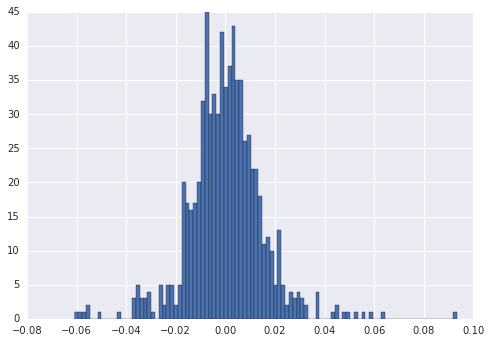

In [78]:
plt.hist(y_orig,bins=100)

In [79]:
mu = np.mean(y_orig)
std = np.std(y_orig)

In [83]:
from scipy.stats import norm
print norm.cdf(x=y_orig[-1], loc=mu, scale=std)
prb = norm.cdf(x=y_orig[-1], loc=mu, scale=std)

0.745524755951


In [111]:
y_cdfs = np.array( [  norm.cdf(x=y_, loc=mu, scale=std) for y_ in y_orig ] )


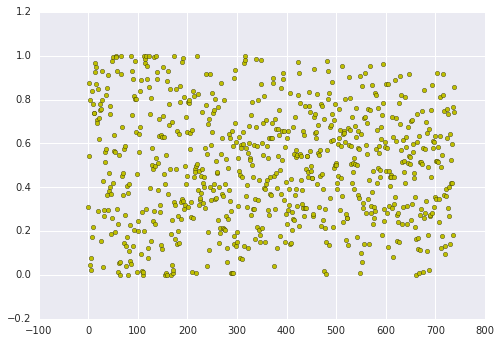

In [113]:
plt.scatter(range(y_cdfs.shape[0]),y_cdfs,c='y')

In [114]:
m = len(y_orig)
y_orig = np.array(y_orig)


def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def safe_log(x, minval=0.0000000001):
    return np.log(x.clip(min=minval))

def computeCost(X, y, theta):
    # 二乗誤差関数ではなく、交差エントロピー誤差関数を使用
    h = sigmoid(np.dot(X, theta))
    J = (1.0 / m) * np.sum(-y * safe_log(h) - (1 - y) * safe_log(1 - h))
    return J

def gradientDescent(X, y, theta, alpha, iterations):
    m = len(y)      # 訓練データ数
    J_history = []  # 各更新でのコスト
    for iter in range(iterations):
        # sigmoid関数を適用する点が線形回帰と異なる
        h = sigmoid(np.dot(X, theta))
        theta = theta - alpha * (1.0 / m) * np.dot(X.T, h - y)
        cost = computeCost(X, y, theta)
        
        J_history.append(cost)
    return theta, J_history

In [123]:
theta = np.zeros(6)
iterations = 30000
alpha = 0.1

# 初期状態のコストを計算
initialCost = computeCost(X, y_cdfs, theta)
print "initial cost:", initialCost

# 勾配降下法でパラメータ推定
theta, J_history = gradientDescent(X, y_cdfs, theta, alpha, iterations)
print "theta:", theta
print "final cost:", J_history[-1]

initial cost: 0.69314718056
theta: [-0.00647735 -0.00651028 -0.00173268  0.01214946  0.04412079 -0.03707343]
final cost: 0.690899387474


In [120]:
h = sigmoid(np.dot(X,theta))

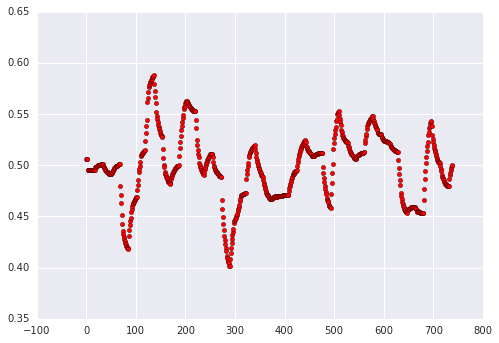

In [124]:
plt.scatter( range(len(h)), h, c='r'   )

In [85]:
print norm.ppf(q=prb, loc=mu, scale=std)
print y_orig[-1]

0.0103058898821
0.0103058898821


In [25]:
df_test_tmp = df_test[  (df_test.id == subset_topid) & (df_test.timestamp == timesplit)]
df_test_tmp.shape

(1, 111)

In [29]:
df_test_tmp[  ["id","y"]  ]

,id,y
806298,0,0.00171


In [31]:
from sklearn.linear_model import ElasticNet 
alpha = 0.1
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

In [35]:
df_tmp_ycumsum = np.cumsum(df_tmp_y)

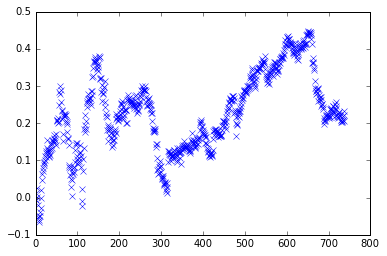

In [36]:
plt.plot(range(h),df_tmp_ycumsum,"x")

In [38]:
enet.fit(np.arange(h)[:,np.newaxis], df_tmp_ycumsum)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [41]:
y_pred = enet.predict(np.arange( h + 1 )[:,np.newaxis] )

In [42]:
print(y_pred[-1])

0.328617675485


In [44]:
len(y_pred[:-1])

739

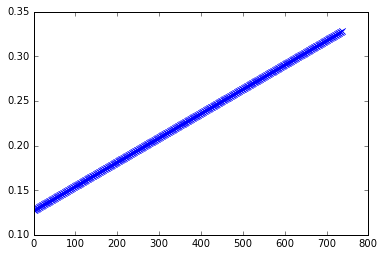

In [47]:
plt.plot(range(h),y_pred[:-1],"x")